In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from skimage import io
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/images_original'
data_dir = pathlib.Path(path)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

Found 999 files belonging to 10 classes.
Using 800 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  image_size=(224, 224),
  seed=123,
  batch_size=32)

Found 999 files belonging to 10 classes.
Using 199 files for validation.


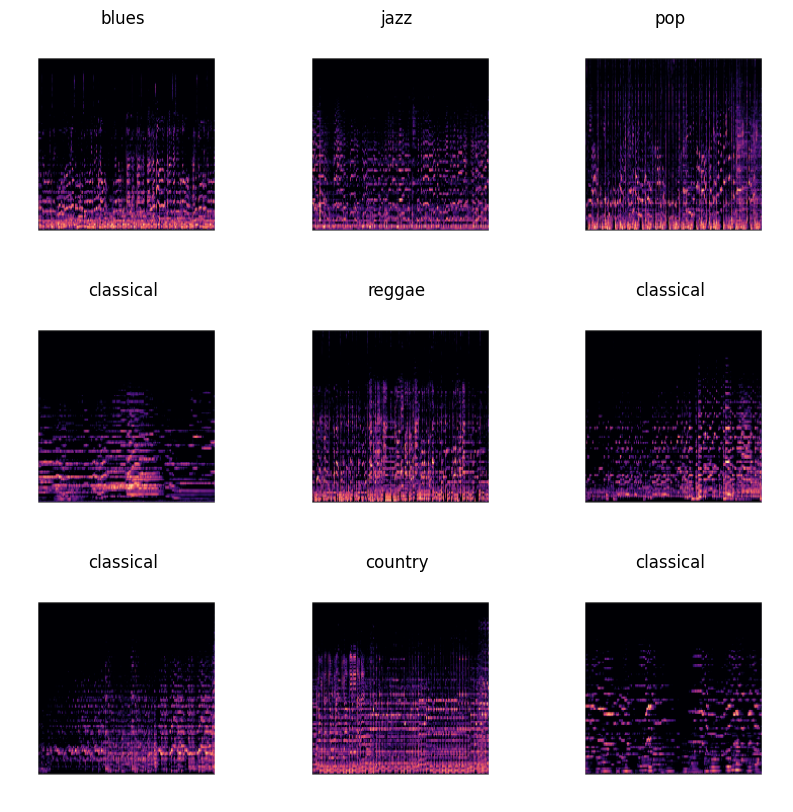

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
preprocess_input=tf.keras.applications.vgg16.preprocess_input
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
new_data=base_model.predict(train_ds)

25/25 [==============================] - 499s 20s/step


In [ ]:
print(new_data.shape)
z=int(0)
for x,y in train_ds:
  if z==0:
    t=y
    z=1
    continue
  t=tf.concat([t, y], 0)
  print(t.shape)
print(t.shape)

(800, 7, 7, 512)
(64,)
(96,)
(128,)
(160,)
(192,)
(224,)
(256,)
(288,)
(320,)
(352,)
(384,)
(416,)
(448,)
(480,)
(512,)
(544,)
(576,)
(608,)
(640,)
(672,)
(704,)
(736,)
(768,)
(800,)
(800,)


In [ ]:
new_data_y=t

In [ ]:
clf = make_pipeline(StandardScaler(),LinearSVC(max_iter=2000))
clf.fit(tf.reshape(new_data, [800, 25088]), new_data_y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(max_iter=2000))])

In [ ]:
num_classes=10
Reshape=tf.keras.layers.Reshape((49, 512), input_shape=(512,))
BidirectionalLSTM=Bidirectional(LSTM(units=256, dropout=0.15, return_sequences=False, input_shape=[49, 512]))
#MonoLSTM=(LSTM(units=32,  dropout=0.05, return_sequences=False))
DenseLayer=Dense(128, activation='relu')
Classify=Dense(num_classes)

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal",input_shape=(224,224,3)),layers.RandomRotation(0.1),layers.RandomZoom(0.1),])

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x=data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = Reshape(x)
x = BidirectionalLSTM(x)
#x = MonoLSTM(x)
x = DenseLayer(x)
outputs = Classify(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 20
history = model.fit(train_ds,epochs=initial_epochs,validation_data=val_ds, callbacks=[callback])